Задание

Цель: разработать скрипт для сбора и обработки данных с использованием API Binance и прогнозирования временных рядов с помощью LSTM-модели.

In [291]:
import requests 
import json 
import pandas as pd 
import numpy as np  
import datetime as dt  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
random.seed(10)

In [137]:
#будем анализировать BTCUSDT c частотой 5 минут и числом наблюдений 1000
frequency = input("Please enter the frequency (1m/5m/30m/.../1h/6h/1d/ :  ")

def get_bars(symbol, interval=frequency):
    root_url = 'https://api.binance.com/api/v3/klines'
    url = root_url + '?symbol=' + symbol + '&interval=' + interval + '&limit=1000' 
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                  'open_price', 'high', 'low', 'close', 'volume',
                  'close_time', 'qav', 'num_trades',
                  'taker_base_vol', 'taker_quote_vol', 'ignore']
    df['date_open'] = pd.to_datetime(df['open_time'], unit = 'ms')
    #df['date_close'] = pd.to_datetime(df['close_time'], unit = 'ms')
    return df

btcusdt = get_bars('BTCUSDT')



df0=pd.DataFrame(btcusdt)
df0.to_csv('_btcusdt.csv')

In [292]:
#в качестве целевого признака примем open_price
data = pd.read_csv('_btcusdt.csv')
data = data.drop(['Unnamed: 0', 'ignore', 'open_time', 'close_time'], axis = 1)
data.tail()


,open_price,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol,date_open
995,28013.99,28013.99,28013.90,28013.91,21.37021,5.986644e+05,1169,11.46302,321124.750947,2023-04-08 05:25:00
996,28013.91,28032.18,28013.90,28031.62,34.22481,9.589740e+05,1358,21.03777,589467.772124,2023-04-08 05:30:00
997,28031.62,28032.17,28028.93,28029.45,42.51748,1.191782e+06,1258,13.57309,380455.535780,2023-04-08 05:35:00
998,28029.45,28041.68,28029.45,28041.67,56.53980,1.585209e+06,1789,33.57187,941257.259329,2023-04-08 05:40:00
999,28041.68,28046.08,28041.67,28046.08,8.54891,2.397313e+05,183,4.53500,127171.602821,2023-04-08 05:45:00


In [293]:
data.isna().sum()# нет Nan

open_price         0
high               0
low                0
close              0
volume             0
qav                0
num_trades         0
taker_base_vol     0
taker_quote_vol    0
date_open          0
dtype: int64

In [294]:
def show_corr_matrix(df, figsize=(20, 20)):
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, vmax=1., vmin=-1., annot=True, fmt='.2f', square=True)

C:\Users\dmoro\AppData\Local\Temp\ipykernel_10092\4278676915.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


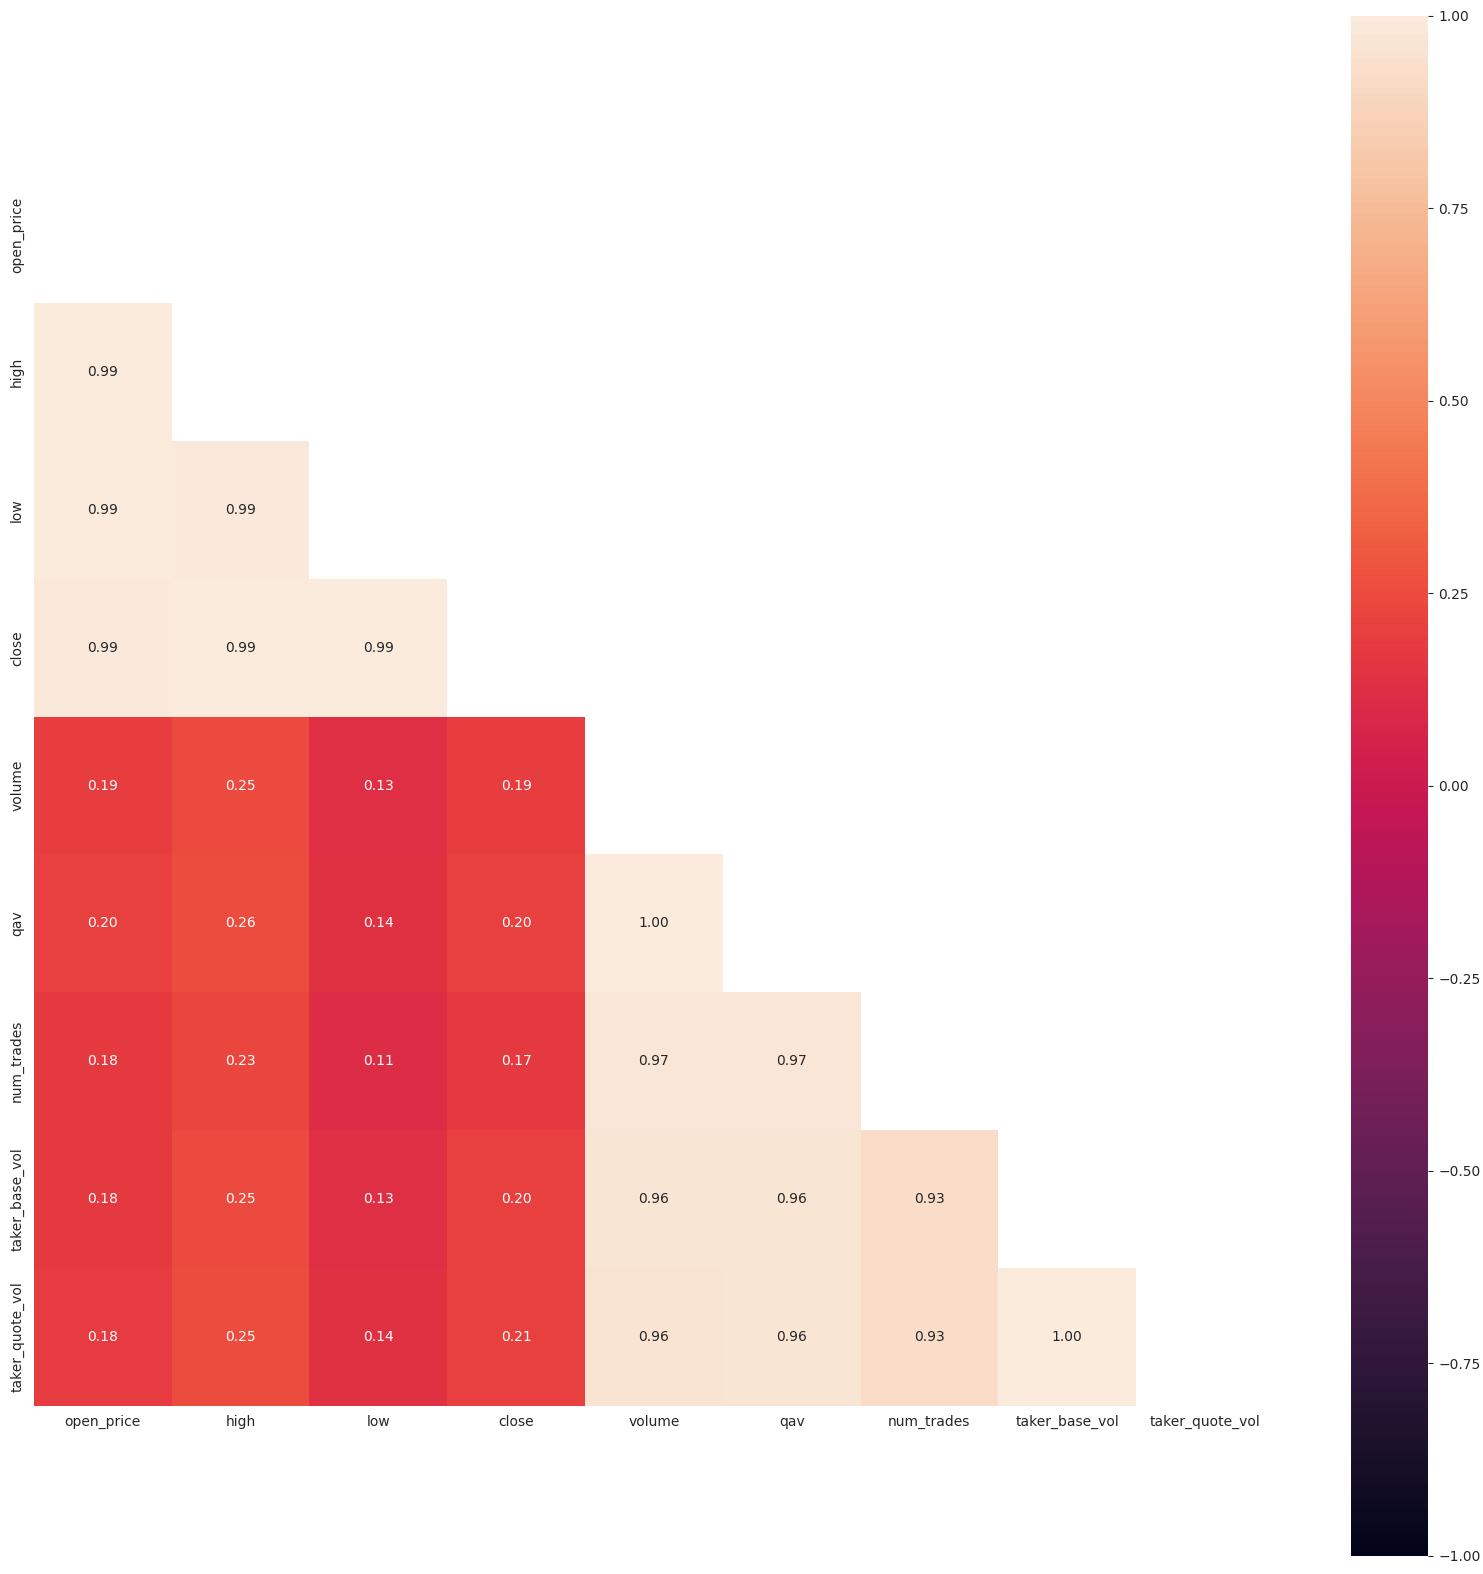

In [295]:
#матрица корреляций, высокая корелляция только с high, low, close, но пока оставим все признаки, 
# в дальнейшем в качестве эксперимента удалим слабокоррелируемые признаки
show_corr_matrix(data)

In [336]:
#разделение выборки
train_size = int(len(data) * 0.988)
X_train, y_train = pd.DataFrame(data.iloc[:train_size, 1:10]), pd.DataFrame(data.iloc[:train_size, 0])
X_test, y_test = pd.DataFrame(data.iloc[train_size:, 1:10]), pd.DataFrame(data.iloc[train_size:, 0])

In [337]:
X_train.shape, y_test.shape, X_test.shape, y_train.shape

((988, 9), (12, 1), (12, 9), (988, 1))

In [338]:
y_test

,open_price
988,27980.03
989,27983.92
990,27984.97
991,27979.03
992,27999.43
993,28011.48
994,28013.12
995,28013.99
996,28013.91
997,28031.62


In [343]:
scaler = MinMaxScaler()
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_nor = scaler_X.fit_transform(X_train.drop(['date_open'], axis = 1))
y_train_nor = scaler_Y.fit_transform(y_train)

X_test_nor = scaler_X.transform(X_test.drop(['date_open'], axis = 1))
y_test_nor = scaler_Y.transform(y_test)

In [301]:
data0 = data[['open_price', 'date_open']]
data0.index = pd.to_datetime(data0['date_open'], unit = 'ns')
data0 = data0.drop(['date_open'], axis = 1)
data0

,open_price
date_open,
2023-04-04 18:30:00,28123.18
2023-04-04 18:35:00,28136.10
2023-04-04 18:40:00,28135.69
2023-04-04 18:45:00,28187.48
2023-04-04 18:50:00,28164.39
...,...
2023-04-08 05:25:00,28013.99
2023-04-08 05:30:00,28013.91
2023-04-08 05:35:00,28031.62


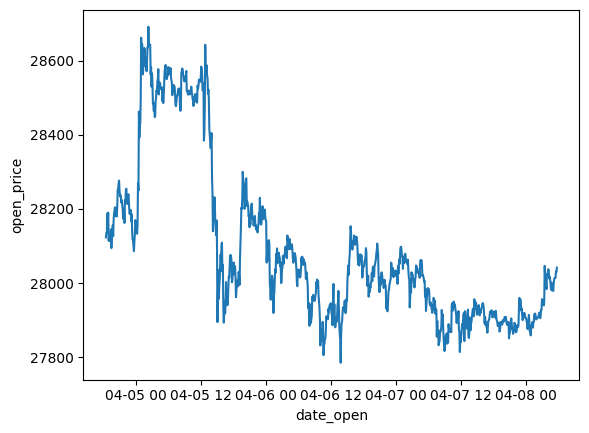

In [302]:
#посмотрим на график для цен на открытие, видно что он нестационарный. В данной работе не будем обрабатывать аномалиии
plt.plot(data0.index, data0['open_price'])
plt.xlabel("date_open")
plt.ylabel("open_price")

plt.show()

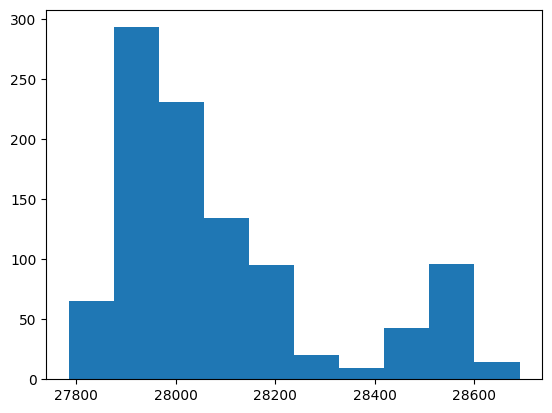

,open_price
count,1000.000000
mean,28091.944080
std,218.395211
min,27785.110000
25%,27925.097500
50%,28025.010000
75%,28171.300000
max,28691.280000


In [303]:
#видно что данные имеют бимодальное распределение
itg = data0.describe()
plt.hist(data0)
plt.show()
itg

In [304]:
#коэффициент вариации
data0.std()/data0.mean()

open_price    0.007774
dtype: float64

In [305]:
#Проведем тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности.
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = jarque_bera(data0)
a = np.vstack([jb_test])
a, row
#Значение данной статистики свидетельствует о том, нулевая гипотеза о нормальности распределения
#  отвергается с малой вероятностью (probably > 0.05), 
# и, следовательно, наш ряд имеет нормальное распределения. Хотя по графику я бы так не сказал

(array([[2.23699405e+02],
        [2.65638705e-49],
        [1.15494328e+00],
        [3.18223562e+00]]),
 ['JB', 'p-value', 'skew', 'kurtosis'])

In [306]:
#Проверим, являются ли данные стационарным временным рядом, для этого существует обобщенный тест Дикки-Фуллера(например,
#  теорема Волда утверждает что любой стационарный ряд может быть описан моделью ARIMA с любой точностью)
test = adfuller(data0)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -1.8401090361054229
p-value:  0.3607382198733019
Critical values:  {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}
есть единичные корни, ряд не стационарен


In [307]:
#За счет дифф ряда мы можем стабилизировать среднее значение ряда и избавиться от тренда 
test = adfuller(data0.diff(periods=1).dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -36.154102079574095
p-value:  0.0
Critical values:  {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}
единичных корней нет, ряд стационарен


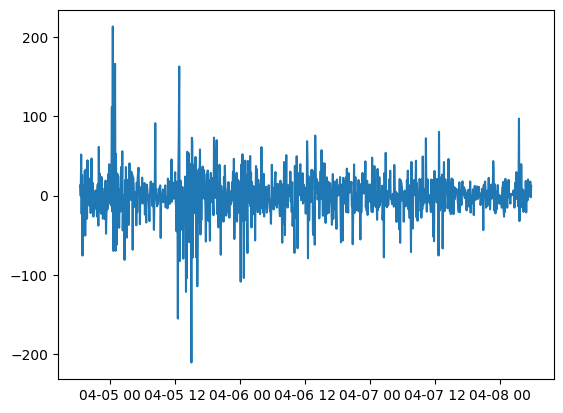

In [308]:
#Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным
plt.plot(data0['open_price'].diff(periods=1).dropna())


plt.show()

Одномерный временной ряд

In [345]:
#Для сравнения с LSTM будем использовать ARIMA
from pmdarima import auto_arima

sarimax_param = auto_arima(y_train_nor, exogenous=X_train_nor, m=7, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-3320.590, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-3577.909, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.04 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-3342.469, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-3694.127, Time=1.15 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-3734.914, Time=1.92 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=6.65 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=7.26 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-3717.620, Time=1.40 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-3734.553, Time=3.47 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=-3734.262, Time=2.98 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=-3733.210, Time=2.55 sec
 ARIMA(2,1,1)(3,1,0)[7]             : AIC=-3732.509, Time=2.69 sec
 ARIMA(1,1,0)(3,1,0)[7] intercept   : AIC=-3732.907, Time=5.48 sec

Best model:  ARIMA(1,1,0)(3,1,0)[7] 

c:\Users\dmoro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


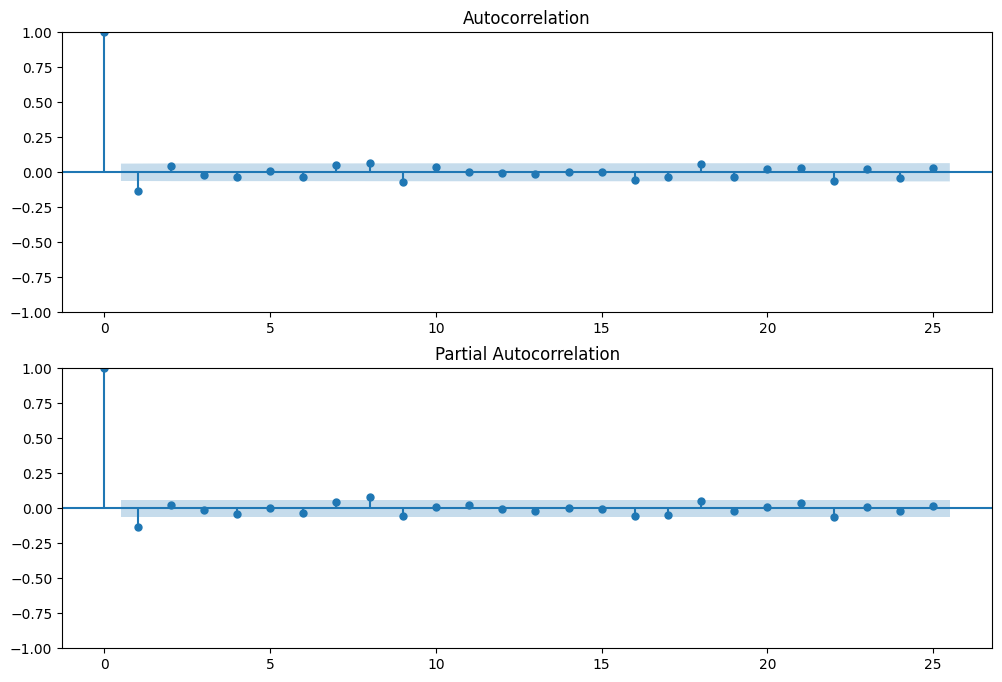

In [313]:
#ACF поможет нам определить q, т. к. по ее коррелограмме можно определить
#  количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
#PACF поможет нам определить p, т. к. по ее коррелограмме можно определить
#  максимальный номер коэффициента сильно отличный от 0 в модели AR.
#сравним с автоподбором
# в целом автоподбор выбрал правильные параметры
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data0.diff(periods=1).dropna().values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data0.diff(periods=1).dropna(), lags=25, ax=ax2)

In [346]:
model = SARIMAX(endog = y_train_nor, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"]).fit(full_output=False, disp=0)

In [347]:
#Как видно из данной информации все коэффициенты значимые и можно перейти к оценке модели.
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  988
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 7)   Log Likelihood                1872.457
Date:                           Sun, 09 Apr 2023   AIC                          -3734.914
Time:                                   15:46:37   BIC                          -3710.476
Sample:                                        0   HQIC                         -3725.617
                                           - 988                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1400      0.027     -5.095      0.000      -0.194      -0.086
ar.S.L7       -0.6948      0.023    -29.621

In [359]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# forecast the data
forecast = model.get_prediction(start=len(y_train_nor), end=len(y_train_nor)+len(y_test_nor)-1, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(y_test, scaler_Y.inverse_transform([prediction])[0], squared=False)
rmse = mean_squared_error(y_test, scaler_Y.inverse_transform([prediction])[0], squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 17.047833 
RMSE = 290.628625


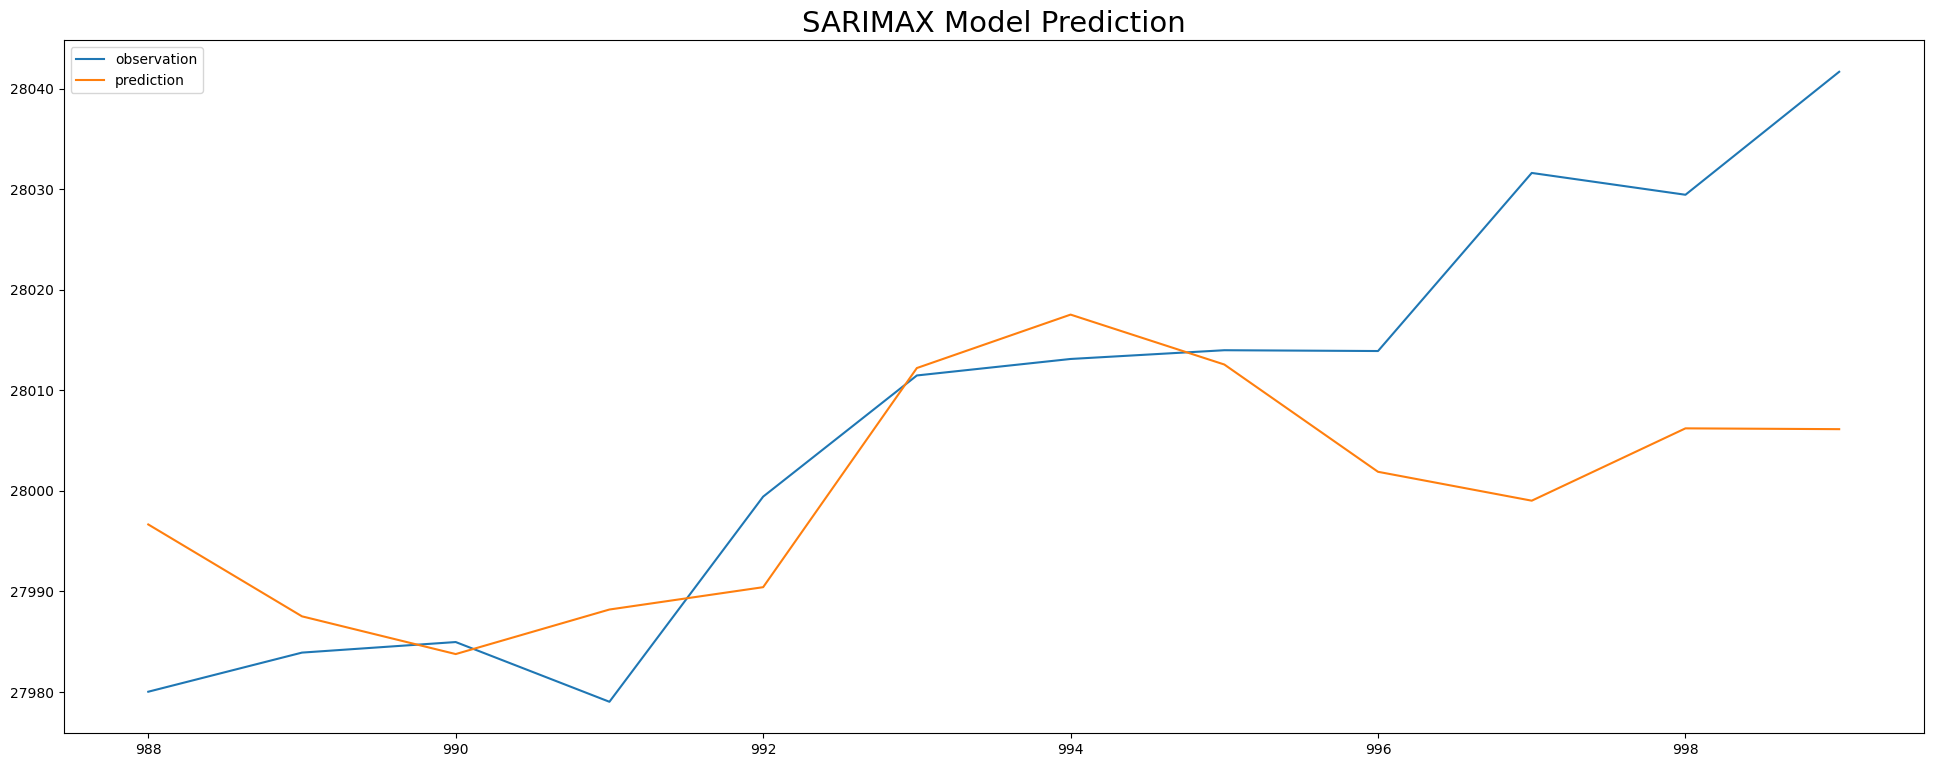

In [366]:
#получили не очень хороший прогноз
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(y_test.index, scaler_Y.inverse_transform([prediction])[0], label="prediction")
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()

Многомерный временной ряд

In [367]:
model = SARIMAX(endog = y_train_nor, exog = X_train_nor, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"]).fit(full_output=False, disp=0)

In [368]:
print(model.summary()) #видими что часть коэфф. незначимы

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  988
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 7)   Log Likelihood                2620.250
Date:                           Sun, 09 Apr 2023   AIC                          -5214.500
Time:                                   15:56:54   BIC                          -5150.962
Sample:                                        0   HQIC                         -5190.328
                                           - 988                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5913      0.022     27.324      0.000       0.549       0.634
x2             0.6332      0.020     31.159

In [374]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


forecast = model.get_prediction(start=len(y_train_nor), end=len(y_train_nor)+len(y_test_nor)-1, exog = X_test_nor, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

mse = mean_squared_error(y_test, scaler_Y.inverse_transform([prediction])[0], squared=False)
rmse = mean_squared_error(y_test, scaler_Y.inverse_transform([prediction])[0], squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 8.091648 
RMSE = 65.474762


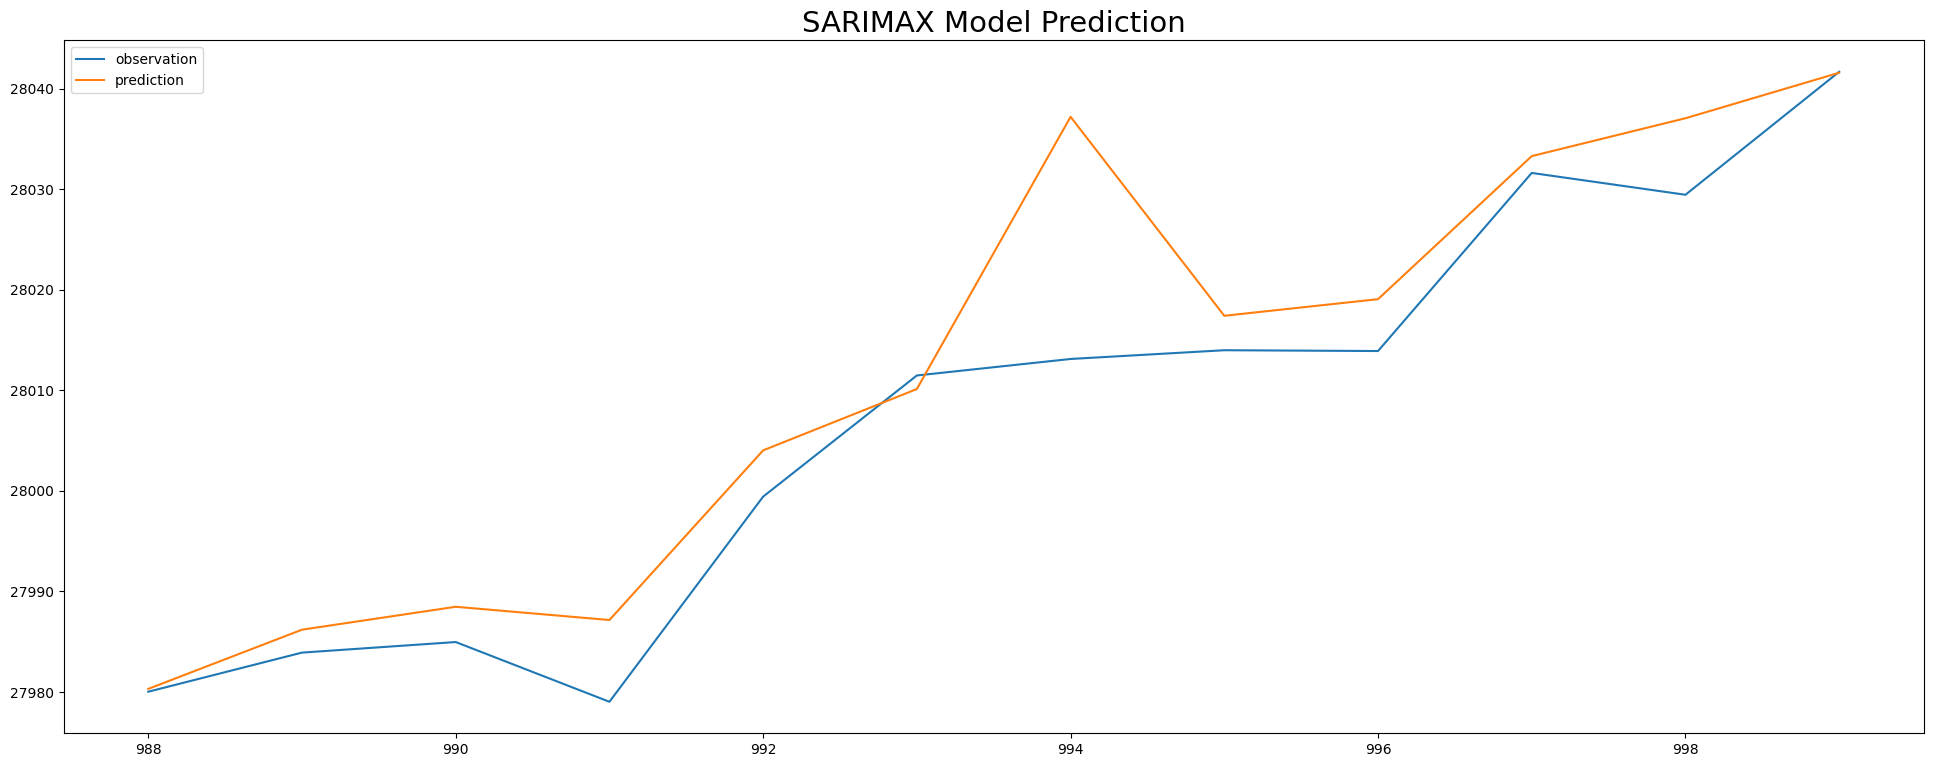

In [375]:
#Довольно таки хороший проноз, за исключением горба в центре, видимо это из-за неправильного параметра для сезонности
# или из-за того что никак не обрабатывались аномалии, а ARIMA очень чуствителен к ним 
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(y_test.index, scaler_Y.inverse_transform([prediction])[0], label="prediction")
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()

Попробуем тоже самое, только удалим незначимые фичи

In [385]:
X_train_cor = np.delete(X_train_nor, (3, 4, 5, 6, 7), 1)
X_test_cor = np.delete(X_test_nor, (3, 4, 5, 6, 7), 1)

In [386]:
model = SARIMAX(endog = y_train_nor, exog = X_train_cor, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"]).fit(full_output=False, disp=0)

In [387]:
print(model.summary()) #оставили только значимые фичи 

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  988
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 7)   Log Likelihood                2445.531
Date:                           Sun, 09 Apr 2023   AIC                          -4875.063
Time:                                   16:13:39   BIC                          -4835.962
Sample:                                        0   HQIC                         -4860.187
                                           - 988                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7340      0.013     55.348      0.000       0.708       0.760
x2             0.7169      0.017     43.159

In [388]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


forecast = model.get_prediction(start=len(y_train_nor), end=len(y_train_nor)+len(y_test_nor)-1, exog = X_test_cor, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

mse = mean_squared_error(y_test, scaler_Y.inverse_transform([prediction])[0], squared=False)
rmse = mean_squared_error(y_test, scaler_Y.inverse_transform([prediction])[0], squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 7.103762 
RMSE = 50.463429


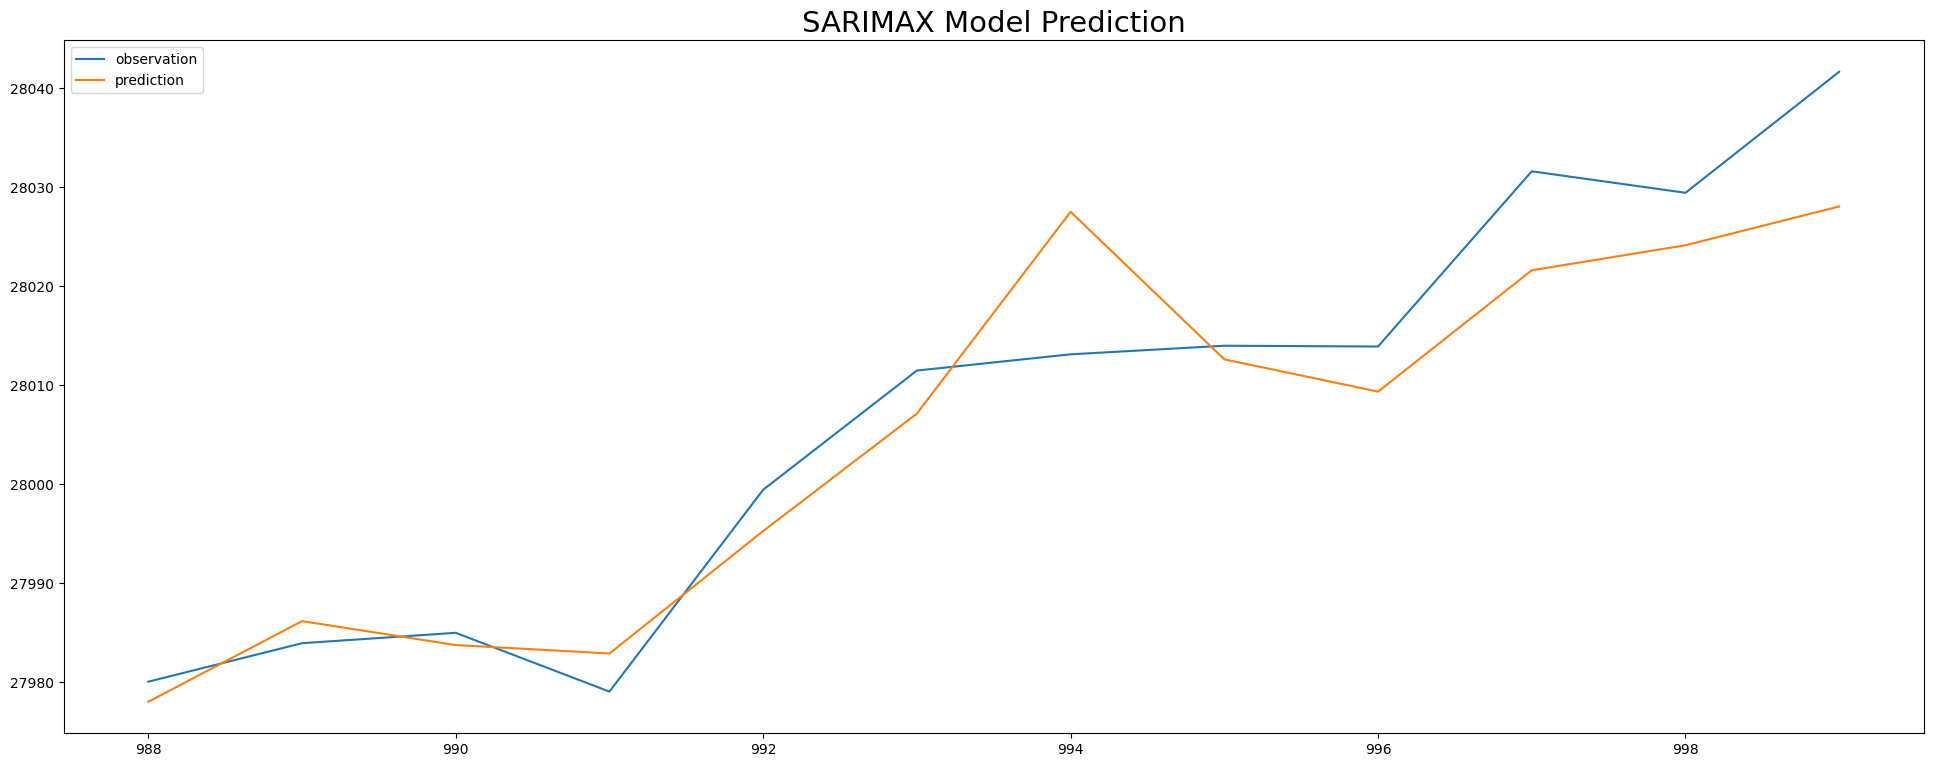

In [389]:
#Получили незначительное улучшение проноза, можно посмотреть на график остатков, но уже не в этой работе
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(y_test.index, scaler_Y.inverse_transform([prediction])[0], label="prediction")
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()

LSTM